In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pufferfish import *
from randomized_response import *
from ldp_optimized import *
from empirical_data import *

In [18]:
# Parameters
err_ord_names = {2: "L2", 1: "L1", -1: "0 1 Loss"}
err_ord = 1 # l2

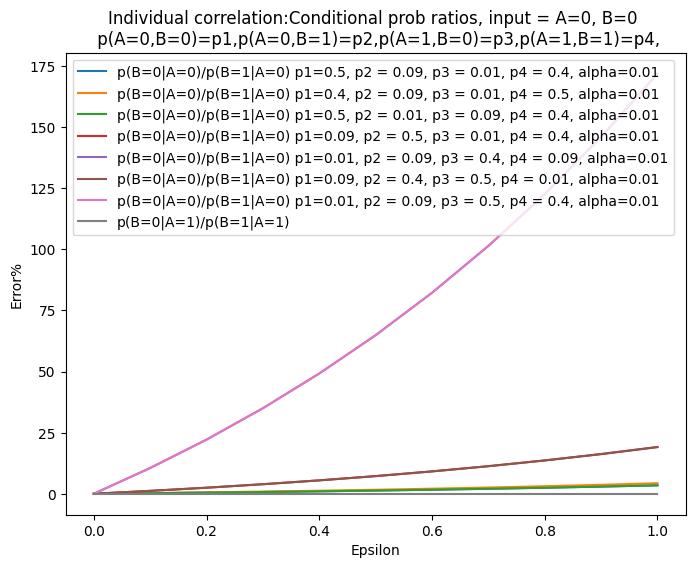

In [19]:
# Generate theoretical errors

# Point-wise correlation between attributes

P = [[0.5, 0.09, 0.01, 0.4], [0.4, 0.09, 0.01, 0.5], [0.5, 0.01, 0.09, 0.4], [0.09, 0.5, 0.01, 0.4], [0.01, 0.09, 0.4, 0.09], [0.09, 0.4, 0.5, 0.01], [0.01, 0.09, 0.5, 0.4]]

def prob_B_0_div_B_1_given_A_0(epsilon, p1, p3, alpha):
    return (np.exp(epsilon)*alpha -alpha+p1)/p3

def prob_B_0_div_B_1_given_A_1(epsilon, p2, p4):
    return p2/p4

epsilon = np.array(np.arange(11))*0.1
# corrected_epsilon = np.array(np.arange(11))*0.1 - np.ones(11)*np.log(min(p1,p2,p3,p4))
legend_ = []

plt.figure(figsize=(8, 6))
for i in P:
    p1 = i[0]
    p2 = i[1]
    p3 = i[2]
    p4 = i[3]

    plt.plot(epsilon, [abs(p1/p3 - prob_B_0_div_B_1_given_A_0(i, p1, p3, min(p1, p2, p3, p4)))* 100/(p1/p3) for i in epsilon])
    legend_.append(f"p(B=0|A=0)/p(B=1|A=0) p1={p1}, p2 = {p2}, p3 = {p3}, p4 = {p4}, alpha={min(p1,p2,p3,p4)}")
legend_.append("p(B=0|A=1)/p(B=1|A=1)")
plt.plot(epsilon, [abs(p2/p4 - prob_B_0_div_B_1_given_A_1(i, p2, p4))* 100/(p2/p4) for i in epsilon])
plt.legend(legend_, loc ="upper left")
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("Individual correlation:Conditional prob ratios, input = A=0, B=0 \n p(A=0,B=0)=p1,p(A=0,B=1)=p2,p(A=1,B=0)=p3,p(A=1,B=1)=p4,")
plt.show()

In [20]:
FILE_LOCATION = "/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/datasets/celeba_anno/list_attr_celeba.txt"
TRAINING_AMOUNT = 0.5

ATTR_X = "Bald"
ATTR_Y = "Black_Hair"

dict_attr_node = {}

xn_train = []
yn_train = []

xn_test = []
yn_test = []

# Reading txt
with open(FILE_LOCATION, 'r') as txt_file:
    no_of_lines = txt_file.readline()
    fields = txt_file.readline()

    for i, attr in enumerate(fields.split()):
      dict_attr_node[attr] = i+1
    print(dict_attr_node)
    # Training dataset
    for i in range(int(int(no_of_lines) * TRAINING_AMOUNT)):
      rows = txt_file.readline().split()
      xn_train.append(rows[dict_attr_node[ATTR_X]])
      yn_train.append(rows[dict_attr_node[ATTR_Y]])
    
    # Test dataset
    for i in range(int(int(no_of_lines) * TRAINING_AMOUNT),int(no_of_lines)):
      rows = txt_file.readline().split()
      xn_test.append(rows[dict_attr_node[ATTR_X]])
      yn_test.append(rows[dict_attr_node[ATTR_Y]])


{'5_o_Clock_Shadow': 1, 'Arched_Eyebrows': 2, 'Attractive': 3, 'Bags_Under_Eyes': 4, 'Bald': 5, 'Bangs': 6, 'Big_Lips': 7, 'Big_Nose': 8, 'Black_Hair': 9, 'Blond_Hair': 10, 'Blurry': 11, 'Brown_Hair': 12, 'Bushy_Eyebrows': 13, 'Chubby': 14, 'Double_Chin': 15, 'Eyeglasses': 16, 'Goatee': 17, 'Gray_Hair': 18, 'Heavy_Makeup': 19, 'High_Cheekbones': 20, 'Male': 21, 'Mouth_Slightly_Open': 22, 'Mustache': 23, 'Narrow_Eyes': 24, 'No_Beard': 25, 'Oval_Face': 26, 'Pale_Skin': 27, 'Pointy_Nose': 28, 'Receding_Hairline': 29, 'Rosy_Cheeks': 30, 'Sideburns': 31, 'Smiling': 32, 'Straight_Hair': 33, 'Wavy_Hair': 34, 'Wearing_Earrings': 35, 'Wearing_Hat': 36, 'Wearing_Lipstick': 37, 'Wearing_Necklace': 38, 'Wearing_Necktie': 39, 'Young': 40}


In [21]:
matrix_symb, symbols_xn, symbols_yn, joint_prob_matrix = joint_prob_binary(xn_train, yn_train)
print(matrix_symb, symbols_xn, symbols_yn, joint_prob_matrix)

matrix_symb_dict = {}
for i,symb in enumerate(matrix_symb):
    matrix_symb_dict[symb] = i
    
#Pufferfish mechanism initialize
p_m = Pufferfish_Binary_Attr(joint_prob_matrix.flatten(), matrix_symb)

["['-1' '-1']", "['1' '-1']", "['-1' '1']", "['1' '1']"] [['-1']
 ['1']] [['-1']
 ['1']] [[7.39039872e-01 2.20831400e-02]
 [2.38610450e-01 2.66537676e-04]]


In [22]:
# Analyze the test dataset

def matrix_coordinate_of_index(rows, columns, index):
    rows_index = index//columns 
    columns_index = index%rows
    return np.array([rows_index, columns_index])

def error_calculation(a, b, order = 2):
    if order == -1:
    # print(" a ", a, " b ", b, " a-b ", a-b)
        if a[0] == b[0] and a[1] == b[1]:
            # print("0")
            return 0
        else:
            # print("1")
            return 1
    return np.linalg.norm(a-b, ord=order)

def fix_joint_probability_matrix(symbols, joint_prob_vector, correct_symbol_count = 4):
    corrected_joint_prob_vector = np.zeros(correct_symbol_count)
    # print(symbols, list(symbols)[0])
    for index_,i in enumerate(list(symbols)):
        corrected_joint_prob_vector[i] = joint_prob_vector[index_]
    
    return corrected_joint_prob_vector

EPS = 0.001

perturbed_output = []
original_dataset = []

# Calculate joint probability matrix for original test dataset
for i in range(len(xn_test)):
    symb_index = matrix_symb_dict[f"['{xn_test[i]}' '{yn_test[i]}']"]
    original_dataset.append(symb_index)
[symbols_original, counts_original] = np.unique(original_dataset, axis=0, return_counts=True)
joint_matrix_original  = counts_original/len(xn_test)
print(joint_matrix_original)

eps_arr = np.arange(50)*0.2
perturbed_join_prob_list = []
error_list = []

# Calculate joint probability matrix for original perturbed dataset
for eps in eps_arr:
    print("eps ", eps)
    inner_error_list = []
    perturbed_output = []
    for i in range(len(xn_test)):
        symb_index = matrix_symb_dict[f"['{xn_test[i]}' '{yn_test[i]}']"]
        perturbed_output.append(p_m.gen_random_output(symb_index, eps, out_index_ = True)[0])
        perturbed_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn),
                                                             perturbed_output[-1])
        original_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn), symb_index)
        # print("index ", perturbed_output[-1], " perturbed_coordinate ", perturbed_coordinate, "symb_index ", symb_index, " original_coordinate ", original_coordinate)
        # print(error_calculation(perturbed_coordinate, perturbed_coordinate))
        error = error_calculation(perturbed_coordinate, original_coordinate, err_ord) * 100 / error_calculation(
            np.array([0, 0]), np.array([len(symbols_yn)-1, len(symbols_xn)-1]))
        inner_error_list.append(error)
    error_list.append(np.sum(np.array(inner_error_list))/len(xn_test))
    [symbols_perturbed, counts_perturbed] = np.unique(perturbed_output, axis=0, return_counts=True)
    joint_matrix_perturbed = fix_joint_probability_matrix(symbols_perturbed, counts_perturbed)/len(xn_test)
    perturbed_join_prob_list.append(joint_matrix_perturbed)


print(joint_matrix_perturbed)
print(joint_matrix_original)
print(error_list)

[7.38153998e-01 2.22211254e-02 2.39308983e-01 3.15893386e-04]
eps  0.0
eps  0.2
eps  0.4
eps  0.6000000000000001
eps  0.8
eps  1.0
eps  1.2000000000000002
eps  1.4000000000000001
eps  1.6
eps  1.8
eps  2.0
eps  2.2
eps  2.4000000000000004
eps  2.6
eps  2.8000000000000003
eps  3.0
eps  3.2
eps  3.4000000000000004
eps  3.6
eps  3.8000000000000003
eps  4.0
eps  4.2
eps  4.4
eps  4.6000000000000005
eps  4.800000000000001
eps  5.0
eps  5.2
eps  5.4
eps  5.6000000000000005
eps  5.800000000000001
eps  6.0
eps  6.2
eps  6.4
eps  6.6000000000000005
eps  6.800000000000001
eps  7.0
eps  7.2
eps  7.4
eps  7.6000000000000005
eps  7.800000000000001
eps  8.0
eps  8.200000000000001
eps  8.4
eps  8.6
eps  8.8
eps  9.0
eps  9.200000000000001
eps  9.4
eps  9.600000000000001
eps  9.8
[7.39210267e-01 2.18657453e-02 2.38598223e-01 3.25765054e-04]
[7.38153998e-01 2.22211254e-02 2.39308983e-01 3.15893386e-04]
[28.949496087018442, 28.854563685990442, 28.81966206796543, 28.746368670112933, 29.006036708218943, 2

[0 1 2 3]


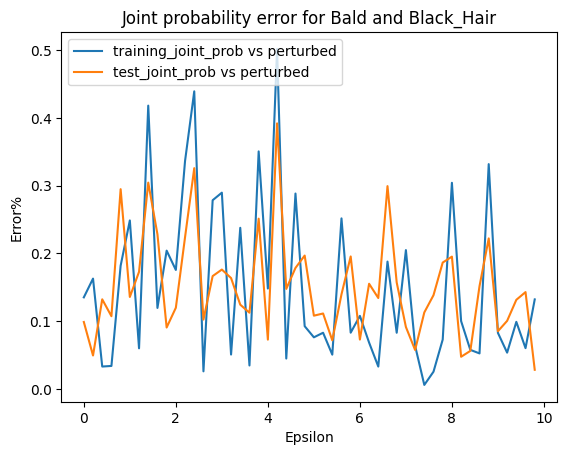

In [23]:
'''
Plot L2 Error joint probability of perturbed data (test) vs original data (test), 
joint probability of perturbed data vs training data
'''

print(symbols_perturbed)

pufferfish_err_joint_matrix_training = [error_calculation(i, joint_matrix_original)*100 for i in perturbed_join_prob_list]
pufferfish_err_joint_matrix_test = [error_calculation(i, joint_prob_matrix.flatten())*100 for i in perturbed_join_prob_list]
# correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
plt.plot(eps_arr, pufferfish_err_joint_matrix_training)
plt.plot(eps_arr, pufferfish_err_joint_matrix_test)
plt.legend(["training_joint_prob vs perturbed", "test_joint_prob vs perturbed"], loc ="upper left")
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("Joint probability error for " + ATTR_X + " and " + ATTR_Y)
plt.show()

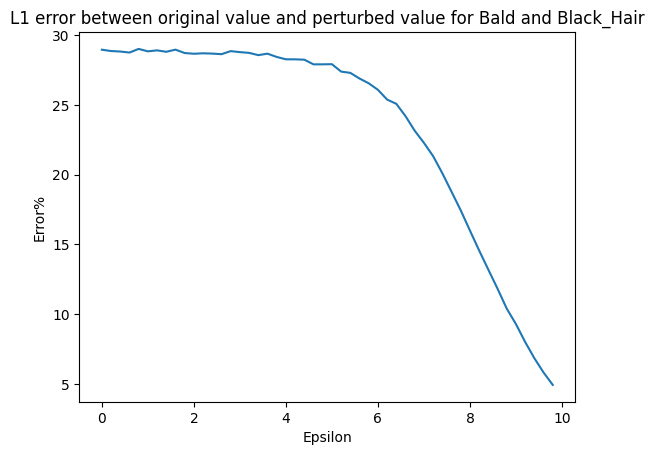

In [24]:
'''
Plot average L2 Error between original value and perturbed value
'''

# correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
puffer_fish_l2_error = error_list
plt.plot(eps_arr, puffer_fish_l2_error)
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title(f"{err_ord_names[err_ord]} error between original value and perturbed value for " + ATTR_X + " and " + ATTR_Y)
plt.show()

In [25]:
# Calculate mutual information between atributes

In [26]:
# Generalized random response

#Pufferfish mechanism initialize
r_m = Randomized_Response_Binary_Attr(joint_prob_matrix.flatten(), matrix_symb)

# Analyze the test dataset

perturbed_output = []
original_dataset = []

perturbed_join_prob_list = []
error_list = []

# Calculate joint probability matrix for original perturbed dataset
for eps in eps_arr:
    print("eps ", eps)
    inner_error_list = []
    perturbed_output = []
    for i in range(len(xn_test)):
        symb_index = matrix_symb_dict[f"['{xn_test[i]}' '{yn_test[i]}']"]
        perturbed_output.append(r_m.gen_random_output(symb_index, eps, out_index_ = True)[0])
        perturbed_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn),
                                                             perturbed_output[-1])
        original_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn), symb_index)
        # print("index ", perturbed_output[-1], " perturbed_coordinate ", perturbed_coordinate, "symb_index ", symb_index, " original_coordinate ", original_coordinate)
        # print(error_calculation(perturbed_coordinate, perturbed_coordinate))
        error = error_calculation(perturbed_coordinate, original_coordinate, err_ord) * 100 / error_calculation(
            np.array([0, 0]), np.array([len(symbols_yn)-1, len(symbols_xn)-1]))
        inner_error_list.append(error)
    error_list.append(np.sum(np.array(inner_error_list))/len(xn_test))
    [symbols_perturbed, counts_perturbed] = np.unique(perturbed_output, axis=0, return_counts=True)
    joint_matrix_perturbed = counts_perturbed/len(xn_test)
    perturbed_join_prob_list.append(joint_matrix_perturbed)


print(joint_matrix_perturbed)
print(joint_matrix_original)
print(error_list)

eps  0.0
eps  0.2
eps  0.4
eps  0.6000000000000001
eps  0.8
eps  1.0
eps  1.2000000000000002
eps  1.4000000000000001
eps  1.6
eps  1.8
eps  2.0
eps  2.2
eps  2.4000000000000004
eps  2.6
eps  2.8000000000000003
eps  3.0
eps  3.2
eps  3.4000000000000004
eps  3.6
eps  3.8000000000000003
eps  4.0
eps  4.2
eps  4.4
eps  4.6000000000000005
eps  4.800000000000001
eps  5.0
eps  5.2
eps  5.4
eps  5.6000000000000005
eps  5.800000000000001
eps  6.0
eps  6.2
eps  6.4
eps  6.6000000000000005
eps  6.800000000000001
eps  7.0
eps  7.2
eps  7.4
eps  7.6000000000000005
eps  7.800000000000001
eps  8.0
eps  8.200000000000001
eps  8.4
eps  8.6
eps  8.8
eps  9.0
eps  9.200000000000001
eps  9.4
eps  9.600000000000001
eps  9.8
[7.37976308e-01 2.22902270e-02 2.39318855e-01 4.14610069e-04]
[7.38153998e-01 2.22211254e-02 2.39308983e-01 3.15893386e-04]
[70.70858402157324, 67.011804640365, 63.000910696931726, 58.564915045953946, 53.92230181626812, 49.651041802368326, 44.710368754749, 40.17315841149869, 35.34835873

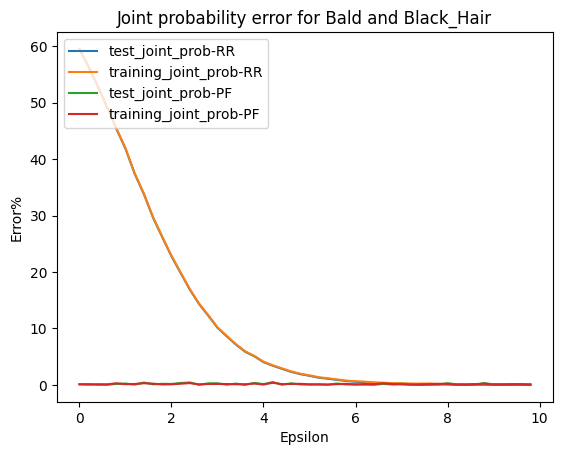

In [27]:
'''
Plot L2 Error joint probability of perturbed data (test) vs original data (test), 
joint probability of perturbed data vs training data
'''
rr_err_joint_matrix_training = [error_calculation(i, joint_matrix_original)*100 for i in perturbed_join_prob_list]
rr_err_joint_matrix_test = [error_calculation(i, joint_prob_matrix.flatten())*100 for i in perturbed_join_prob_list]

# correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
plt.plot(eps_arr, rr_err_joint_matrix_training)
plt.plot(eps_arr, rr_err_joint_matrix_test)
plt.plot(eps_arr, pufferfish_err_joint_matrix_training)
plt.plot(eps_arr, pufferfish_err_joint_matrix_test)
plt.legend(["test_joint_prob-RR", "training_joint_prob-RR", "test_joint_prob-PF", "training_joint_prob-PF",], loc ="upper left")
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("Joint probability error for " + ATTR_X + " and " + ATTR_Y)
plt.show()

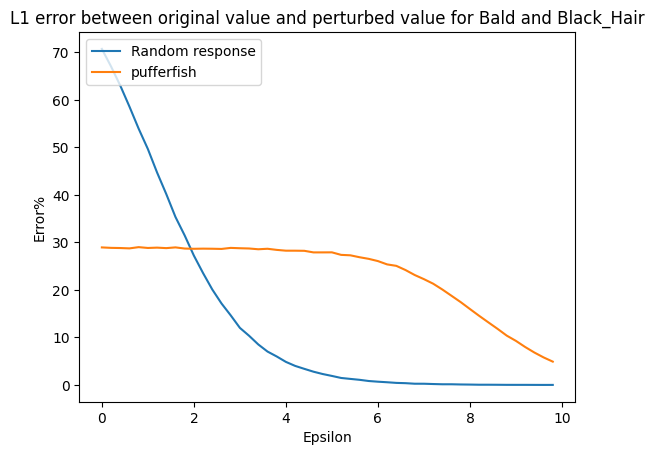

In [28]:
'''
Plot average L2 Error between original value and perturbed value
'''

# correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
rr_l2_error = error_list
plt.plot(eps_arr, rr_l2_error)
plt.plot(eps_arr, puffer_fish_l2_error)
plt.legend(["Random response", "pufferfish"], loc ="upper left")
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title(f"{err_ord_names[err_ord]} error between original value and perturbed value for " + ATTR_X + " and " + ATTR_Y)
plt.show()

In [29]:
#LDP mechanism initialize

ldp = LDP_mechanism(joint_prob_matrix.flatten(), matrix_symb)

perturbed_output = []
original_dataset = []

# Calculate joint probability matrix for original test dataset
for i in range(len(xn_test)):
    symb_index = matrix_symb_dict[f"['{xn_test[i]}' '{yn_test[i]}']"]
    original_dataset.append(symb_index)
[symbols_original, counts_original] = np.unique(original_dataset, axis=0, return_counts=True)
joint_matrix_original  = counts_original/len(xn_test)
print(joint_matrix_original)

eps_arr = np.arange(50)*0.2
perturbed_join_prob_list = []
error_list = []

# Calculate joint probability matrix for original perturbed dataset
for eps in eps_arr:
    print("eps ", eps)
    inner_error_list = []
    perturbed_output = []
    perturbed_matrix = ldp.cal_probabilities(eps, 0.01, 4, err_ord = err_ord)
    for i in range(len(xn_test)):
        symb_index = matrix_symb_dict[f"['{xn_test[i]}' '{yn_test[i]}']"]
        perturbed_output.append(ldp.gen_random_output(symb_index, out_index_ = True, prob_matrix = perturbed_matrix)[0])
        perturbed_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn),
                                                             perturbed_output[-1])
        original_coordinate = matrix_coordinate_of_index(len(symbols_yn), len(symbols_xn), symb_index)
        # print("index ", perturbed_output[-1], " perturbed_coordinate ", perturbed_coordinate, "symb_index ", symb_index, " original_coordinate ", original_coordinate)
        # print(error_calculation(perturbed_coordinate, perturbed_coordinate))
        error = error_calculation(perturbed_coordinate, original_coordinate, err_ord) * 100 / error_calculation(
            np.array([0, 0]), np.array([len(symbols_yn)-1, len(symbols_xn)-1]))
        # print(error)
        inner_error_list.append(error)
    error_list.append(np.sum(np.array(inner_error_list))/len(xn_test))
    [symbols_perturbed, counts_perturbed] = np.unique(perturbed_output, axis=0, return_counts=True)
    joint_matrix_perturbed = fix_joint_probability_matrix(symbols_perturbed, counts_perturbed)/len(xn_test)
    perturbed_join_prob_list.append(joint_matrix_perturbed)


print(joint_matrix_perturbed)
print(joint_matrix_original)
print(error_list)

[7.38153998e-01 2.22211254e-02 2.39308983e-01 3.15893386e-04]
eps  0.0
n  4  alpha  0.01  EPS  0.0
[[0. 1. 1. 2.]
 [1. 0. 2. 1.]
 [1. 2. 0. 1.]
 [2. 1. 1. 0.]]
Optimized Matrix P:
 [[0.25000009 0.24999954 0.24999954 0.25000081]
 [0.24999954 0.25000009 0.25000081 0.24999954]
 [0.24999954 0.25000081 0.25000009 0.24999954]
 [0.25000081 0.24999954 0.24999954 0.25000009]]
Original Distribution Z:
 [0.25, 0.25, 0.25, 0.25]
Perturbed Distribution Z:
 [0.25 0.25 0.25 0.25]


eps  0.2
n  4  alpha  0.01  EPS  0.2
[[0. 1. 1. 2.]
 [1. 0. 2. 1.]
 [1. 2. 0. 1.]
 [2. 1. 1. 0.]]
Optimized Matrix P:
 [[0.28933575 0.23688808 0.23688808 0.23688808]
 [0.23688808 0.28933575 0.23688808 0.23688808]
 [0.23688808 0.23688808 0.28933575 0.23688808]
 [0.23688808 0.23688808 0.23688808 0.28933575]]
Original Distribution Z:
 [0.25, 0.25, 0.25, 0.25]
Perturbed Distribution Z:
 [0.25 0.25 0.25 0.25]
eps  0.4
n  4  alpha  0.01  EPS  0.4
[[0. 1. 1. 2.]
 [1. 0. 2. 1.]
 [1. 2. 0. 1.]
 [2. 1. 1. 0.]]
Optimized Matrix P:
 [[0.33211953 0.22262679 0.22262679 0.22262688]
 [0.22262679 0.33211953 0.22262688 0.22262679]
 [0.22262679 0.22262688 0.33211953 0.22262679]
 [0.22262688 0.22262679 0.22262679 0.33211953]]
Original Distribution Z:
 [0.25, 0.25, 0.25, 0.25]
Perturbed Distribution Z:
 [0.25 0.25 0.25 0.25]
eps  0.6000000000000001
n  4  alpha  0.01  EPS  0.6000000000000001
[[0. 1. 1. 2.]
 [1. 0. 2. 1.]
 [1. 2. 0. 1.]
 [2. 1. 1. 0.]]
Optimized Matrix P:
 [[0.37786686 0.20737772 0.20737772 

[0 1 2 3]


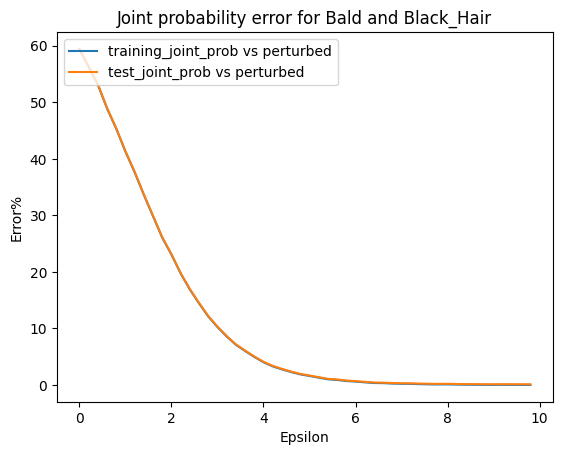

In [30]:
'''
Plot L2 Error joint probability of perturbed data (test) vs original data (test), 
joint probability of perturbed data vs training data
'''

print(symbols_perturbed)

ldp_err_joint_matrix_training = [error_calculation(i, joint_matrix_original)*100 for i in perturbed_join_prob_list]
ldp_err_joint_matrix_test = [error_calculation(i, joint_prob_matrix.flatten())*100 for i in perturbed_join_prob_list]
# correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
plt.plot(eps_arr, ldp_err_joint_matrix_training)
plt.plot(eps_arr, ldp_err_joint_matrix_test)
plt.legend(["training_joint_prob vs perturbed", "test_joint_prob vs perturbed"], loc ="upper left")
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("Joint probability error for " + ATTR_X + " and " + ATTR_Y)
plt.show()

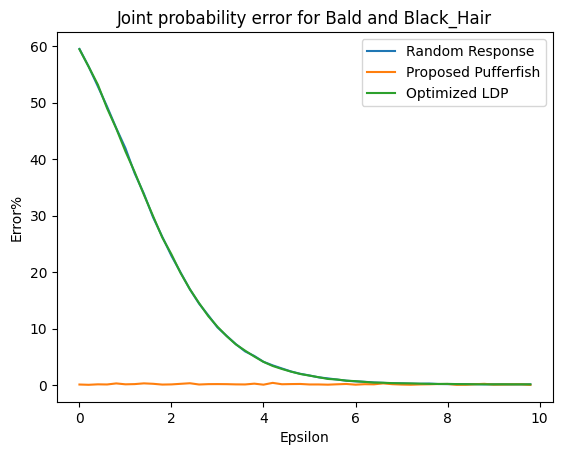

In [31]:
'''
Plot L2 Error joint probability of perturbed data 
joint probability of perturbed data vs training data
'''

plt.plot(eps_arr, rr_err_joint_matrix_test)
plt.plot(eps_arr, pufferfish_err_joint_matrix_test)
plt.plot(eps_arr, ldp_err_joint_matrix_test)
plt.legend(["Random Response", "Proposed Pufferfish", "Optimized LDP"])
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title("Joint probability error for " + ATTR_X + " and " + ATTR_Y)
plt.show()

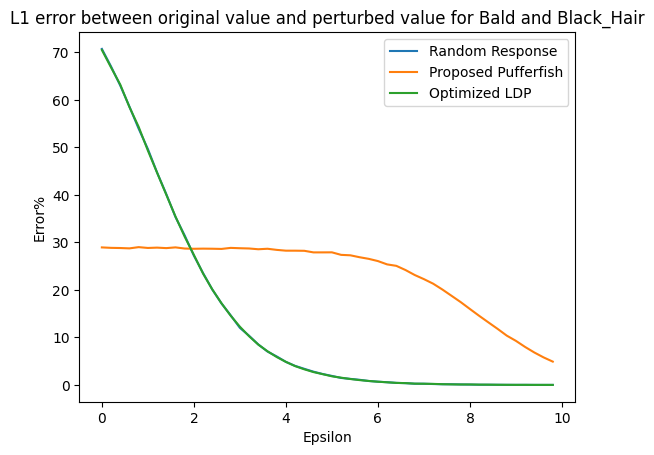

In [32]:
'''
Plot average L2 Error between original value and perturbed value
'''

# correct_eps = eps_arr - np.ones(len(eps_arr))*np.log(np.min(joint_prob_matrix.flatten()))
ldp_l2_error = error_list
plt.plot(eps_arr, rr_l2_error)
plt.plot(eps_arr, puffer_fish_l2_error)
plt.plot(eps_arr, ldp_l2_error)
plt.legend(["Random Response", "Proposed Pufferfish", "Optimized LDP"])
plt.xlabel("Epsilon")
plt.ylabel("Error%")
plt.title(f"{err_ord_names[err_ord]} error between original value and perturbed value for " + ATTR_X + " and " + ATTR_Y)
plt.show()